# Importing Libraries:

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, auc, log_loss, confusion_matrix,f1_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

# Reading Data:

In [2]:
data = pd.read_csv('training_variants')

In [3]:
print(data.shape)
data.head(4)

(3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3


In [4]:
# Text data
data2 = pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
print(data2.shape)
data2.head(4)

(3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...


# Data Cleaning:

In [6]:
# Checking null values for [Gene]:

idx = data['Gene'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are some null values')

There are NO null values


In [7]:
# Checking null values for [Variation]:

idx = data['Variation'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are some null values')

There are NO null values


In [8]:
# Checking null values for [TEXT]:

idx = data2['TEXT'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are SOME null values')

There are SOME null values


In [9]:
idx1 = data2[data2.isna().any(axis=1)]
print('The following are the NaN values for TEXT:')
idx1

The following are the NaN values for TEXT:


,ID,TEXT
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


- since there are only 5 points with NaN values, we could drop these ID's. But, we already have small dataset so we have to find a workaround these nan values instead of throwing them.

In [10]:
# Merging the two datasets on ID:

data_ = pd.merge(data, data2,on='ID', how='left')
data_.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
# Workaround for nan values of [TEXT]: We include the [Gene] type and [Variation] name in the [TEXT] column

data_.loc[data_['TEXT'].isnull(),'TEXT'] = data_['Gene'] +' '+data_['Variation']

In [12]:
idx3 = data.isnull().values.any()
if idx3 == False:
    print('There are NO null values in the dataset.')
else:
    print('There are SOME null values')

There are NO null values in the dataset.


In [13]:
# Cleaning the [TEXT]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

def clean(text):
    '''
    This function gets rid of all punctuation marks, special characters, stop words
    and expands the contracted words and returns words after applying stemming
    
    '''
    sent = text.lower().strip()
    sent = re.sub('[^a-zA-Z]',' ',text)
    sent = sent.split()
    final = [word for word in sent if not word in set(stop_words)]
    final_sent =  ' '.join(final)
    return final_sent

v = data_.TEXT.values
text = [] 
for z in tqdm(range(len(v))):
    r1 = clean((v[z]))
    text.append(r1)

[nltk_data] Downloading package stopwords to C:\Users\PANCHAYAT
[nltk_data]     SAMITI 01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


100%|██████████████████████████████████████████████████████████████████████████████| 3321/3321 [02:41<00:00, 20.59it/s]


In [14]:
# Adding the cleaned TEXT in the dataset:
data_['TEXT'] = text

In [15]:
# Defining the dependent and independent variables:

#x = data_.drop(['Class'],axis = 1)
#y = data_['Class']

# Data Visualisation:

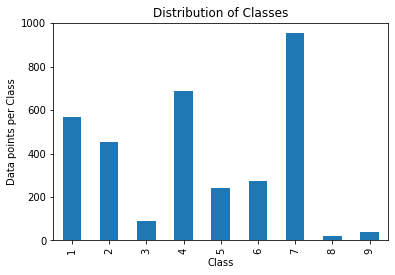

Number of data points in class 7 : 953 ( 28.696 %)
Number of data points in class 4 : 686 ( 20.656 %)
Number of data points in class 1 : 568 ( 17.103 %)
Number of data points in class 2 : 452 ( 13.61 %)
Number of data points in class 6 : 275 ( 8.281 %)
Number of data points in class 5 : 242 ( 7.287 %)
Number of data points in class 3 : 89 ( 2.68 %)
Number of data points in class 9 : 37 ( 1.114 %)
Number of data points in class 8 : 19 ( 0.572 %)


In [16]:
class_distribution = data['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Classes')
plt.show()
print('='*100)

sorted_class = np.argsort(-class_distribution.values)
for i in sorted_class:
    print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data.shape[0]*100), 3), '%)')

# Gene:

In [17]:
genes = data['Gene'].value_counts()
genes1 = len(np.unique(np.array(data["Gene"])))
print('The number of unique Genes in the dataset are:',genes1)
genes.head(7)

The number of unique Genes in the dataset are: 264


BRCA1    264
TP53     163
EGFR     141
PTEN     126
BRCA2    125
KIT       99
BRAF      93
Name: Gene, dtype: int64

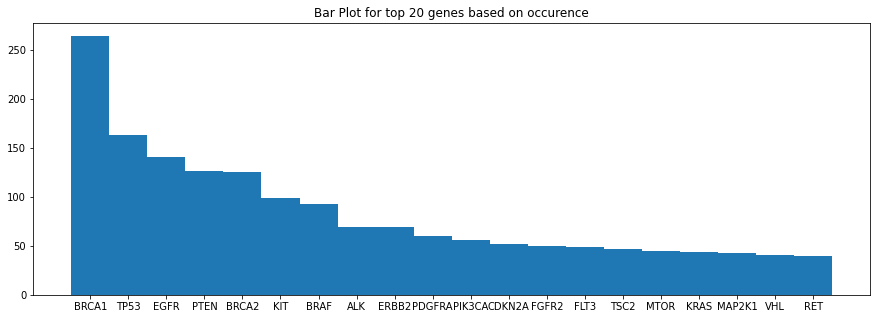

In [18]:
thisdict = (dict(genes))
gene = []
for x in thisdict.keys():
    gene.append(x)

count = []
for y in thisdict.values():
    count.append(y)

plt.figure(figsize=(15, 5))
x_axis = gene[:20]
y_axis = count[:20]
plt.bar(x_axis,y_axis,width = 1)
plt.title('Bar Plot for top 20 genes based on occurence')
plt.show()

# Variation:

In [19]:
variation = data['Variation'].value_counts()
variation1 = len(np.unique(np.array(data["Variation"])))
print('The number of unique Variations in the dataset are:',variation1)
variation

The number of unique Variations in the dataset are: 2996


Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
K607T                    1
T1852S                   1
K147E                    1
R80L                     1
T1977I                   1
Name: Variation, Length: 2996, dtype: int64

# Confusion matrix, Precision,Recall:

In [20]:
def conufsion_precision_recall(y_actual, y_predict):
    '''
    This function plots the confusion matrix, recall & precision
    
    '''
    C = confusion_matrix(y_actual, y_predict)     
    
    precision =(C/C.sum(axis=0)) # dividing each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    # sum of column elements = 1
    
    recall =(((C.T)/(C.sum(axis=1))).T) # dividing each element of the confusion matrix with the sum of elements in that row
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    

    labels = [1,2,3,4,5,6,7,8,9] # since we have 9 classes

    # Confusion Matrix
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(20,5))
    sns.heatmap(precision, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Precision Matrix')
    plt.show()
    
    plt.figure(figsize=(20,5))
    sns.heatmap(recall, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Recall Matrix')
    plt.show()

# Splitting the Data:

In [21]:
y_actual = data_['Class']

x_train,x_test,y_train,y_test = train_test_split(data_,y_actual,test_size = 0.2,stratify = y_actual,random_state = 0)

x_trnew,x_cv,y_trnew,y_cv = train_test_split(x_train,y_train,test_size = 0.2,stratify = y_train,random_state = 0)

In [22]:
print('Original train data shape',x_train.shape)
print('='*100)
print('Original test data shape',x_test.shape)
print('='*100)
print('New train shape',x_trnew.shape)
print('='*100)
print('CV shape',x_cv.shape)
print('='*100)

Original train data shape (2656, 5)
Original test data shape (665, 5)
New train shape (2124, 5)
CV shape (532, 5)


# Data Preprocessing: 

# Response Coding:

In [23]:
def response_code(alpha,feature, data):
    ''' 
    This function creates a 9 dimensional vector(9 classes) of probability values for the given Gene/Variation as input
    
    '''
    value_count = x_train[feature].value_counts() # we only use (x_train) for creating the probability vector and keep the
                                                  # test dataset unseen for avoiding data leakage
    gv_dict = dict() # this dictionary has key: Gene/variation & value: probability values for 9 different classes
    # number is the count of a particular feature(gene/variation) that occurs in the dataset
    
    for i, number in value_count.items(): # value_count.items---> it gives a key,Value pair
        vec = [] # this list contains the probability of a gene belonging to different classes(9)
        
        for k in range(1,10): # this loop runs for each class (9)
            count = x_train.loc[(x_train[feature]==i) & (x_train['Class']==k)] 
            vec.append((count.shape[0] + alpha*1)/ (number + 9*alpha))
        '''
        ((Number of rows where feature = i & class = k) + 1*alpha)/((number of times we see feature = i) + 9*alpha)
        '''
        gv_dict[i]=vec # adding the gene/variation to the dict as key and vec(probability values of 9 classes) as value
    return gv_dict

def call_response_coded_feature(alpha, feature, data):
    ''' For a given feature this function returns probability vector if that feature is present in dataset
        If the feature is not present in the dataset then it returns uniform probability of (1/9)
    '''
    
    probability = response_code(alpha, feature, data) # calling the function to get probability vector
    value_count = x_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the probabilities for each feature value in the data
    gv_fea = []
    
    for index, row in data.iterrows():
        if row[feature] in dict(value_count).keys(): 
            gv_fea.append(probability[row[feature]]) # if gene is already present in the dictionary we created then append 
                                                     # the corresponding probability values
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9]) # if gene not present then append (1/9) as probability for each class
    return gv_fea

In [24]:
# Response Coding on Gene

alpha = 1
gene_train_orig = np.array(call_response_coded_feature(alpha,'Gene', x_train))
gene_test_orig = np.array(call_response_coded_feature(alpha,'Gene', x_test))
gene_train_new =  np.array(call_response_coded_feature(alpha,'Gene', x_trnew))
gene_ohe_cv =  np.array(call_response_coded_feature(alpha,'Gene', x_cv))

print('Original train data shape',gene_train_orig.shape)
print('='*100)
print('Original test data shape',gene_test_orig.shape)
print('='*100)

Original train data shape (2656, 9)
Original test data shape (665, 9)


In [25]:
# Response Coding on Variation:

variation_train_orig =  np.array(call_response_coded_feature(alpha,'Variation', x_train))
variation_test_orig = np.array(call_response_coded_feature(alpha,'Variation', x_test))
variation_train_new = np.array(call_response_coded_feature(alpha,'Variation', x_trnew))
variation_ohe_cv = np.array(call_response_coded_feature(alpha,'Variation', x_cv))

print('Original train data shape',variation_train_orig.shape)
print('='*100)
print('Original test data shape',variation_test_orig.shape)
print('='*100)

Original train data shape (2656, 9)
Original test data shape (665, 9)


In [26]:
# TF-IDF on TEXT:

tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=1000)

text_train_orignal = tfidf.fit_transform(x_train['TEXT'].values)
text_test_orignal = tfidf.transform(x_test['TEXT'].values)
text_train_new = tfidf.transform(x_trnew['TEXT'].values)
text_cv = tfidf.transform(x_cv['TEXT'].values)

print('After TF-IDF')
print('Original train data shape',text_train_orignal.shape)
print('='*100)
print('Original test data shape',text_test_orignal.shape)

After TF-IDF
Original train data shape (2656, 1000)
Original test data shape (665, 1000)


# Concatenating the features:

In [27]:
X_train = hstack((gene_train_orig,variation_train_orig,text_train_orignal)).tocsr()
X_test = hstack((gene_test_orig,variation_test_orig,text_test_orignal)).tocsr()
X_trn = hstack((gene_train_new,variation_train_new,text_train_new)).tocsr()
X_cv = hstack((gene_ohe_cv,variation_ohe_cv,text_cv)).tocsr()
print("="*100)
print("Final Data matrix")
print('Train data shape:',X_train.shape, y_train.shape)
print('Test data shape:',X_test.shape, y_test.shape)
print('CV data shape:',X_cv.shape, y_cv.shape)
print("="*100)

Final Data matrix
Train data shape: (2656, 1018) (2656,)
Test data shape: (665, 1018) (665,)
CV data shape: (532, 1018) (532,)


# Models:

# Logistic Regression:

In [30]:
alpha = [10**-3,10**-2,0.1,1,5,10,50] # hyperparameter for SGD classifier.

log_error_array=[] # this list contains the log-loss obtained with different values of alpha
for i in (alpha):
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', class_weight = 'balanced', random_state=0) # balancing the class_labels
    clf.fit(X_trn, y_trnew)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") # to get predictions in form of probabilities to use log_loss as a metric
    sig_clf.fit(X_trn, y_trnew)
    predict_y = sig_clf.predict_proba(X_cv) 
    
    log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))


best_alpha = np.argmin(log_error_array) # selecting the alpha with minimum log_loss
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=0)
clf.fit(X_train, y_train) # now fitting on entire train data
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_ytrain = sig_clf.predict_proba(X_train) # getting log_loss on train set, to check overfitting
print('*'*100)
print('The best alpha value = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_ytrain, labels=clf.classes_))
predict_ytest = sig_clf.predict_proba(X_test)
print('*'*100)
print('The best alpha value = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_ytest, labels=clf.classes_))

For values of alpha =  0.001 The log loss is: 0.27319906389633986
For values of alpha =  0.01 The log loss is: 1.087234805766545
For values of alpha =  0.1 The log loss is: 1.7627144496757572
For values of alpha =  1 The log loss is: 1.8303537020600802
For values of alpha =  5 The log loss is: 1.8303537020583556
For values of alpha =  10 The log loss is: 1.8303537020582756
For values of alpha =  50 The log loss is: 1.8303537020582372
****************************************************************************************************
The best alpha value =  0.001 The train log loss is: 0.30982371901551065
****************************************************************************************************
The best alpha value =  0.001 The test log loss is: 1.2392608088767685


- For the best value of alpha our Logistic regression model is overfitting.
- So, we will be using a different value of alpha

In [37]:
clf_new = SGDClassifier(alpha=0.005, penalty='l2', loss='log', random_state=0) # using the l2 regularizer
clf_new.fit(X_train, y_train) # now fitting on entire train data
sig_clf_new = CalibratedClassifierCV(clf_new, method="sigmoid")
sig_clf_new.fit(X_train, y_train)

predict_ytrain = sig_clf_new.predict_proba(X_train) # getting log_loss on train set, to check overfitting
print('*'*100)
print("The train log loss is:",log_loss(y_train, predict_ytrain, labels=clf_new.classes_))
predict_ytest = sig_clf_new.predict_proba(X_test)
print('*'*100)
print("The test log loss is:",log_loss(y_test, predict_ytest, labels=clf_new.classes_))

****************************************************************************************************
The train log loss is: 0.8214564453764587
****************************************************************************************************
The test log loss is: 1.0480439282304685


c:\users\panchayat  samiti 01\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in true_divide



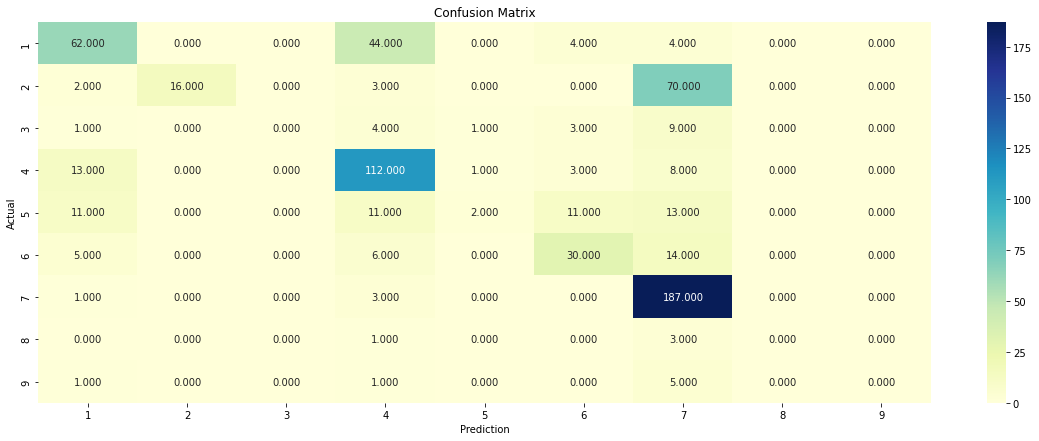

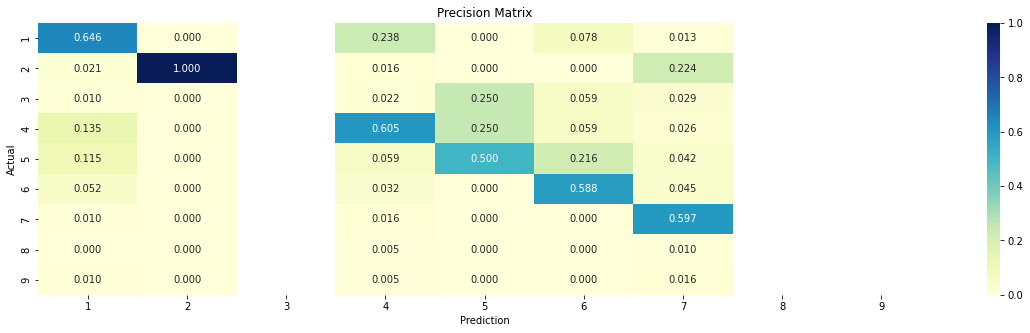

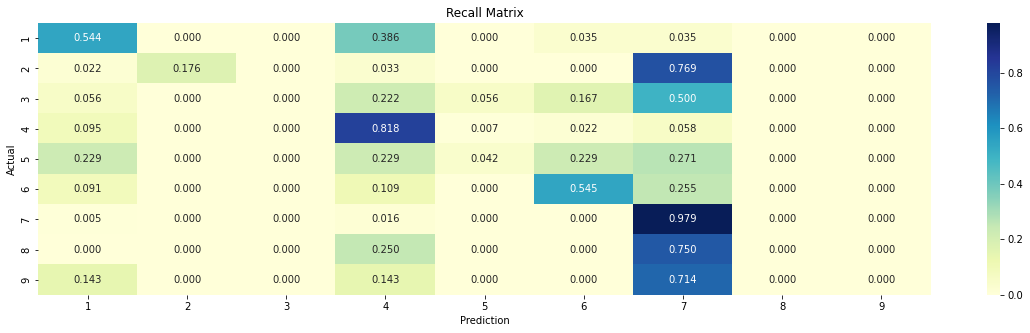

In [37]:
# Confusion matrix for Logistic Regression:0

x1 = conufsion_precision_recall(y_test,y_pred_lr)
x1

# Random Forest: Hyperparameter tuning

In [32]:
trees = [5,8,10,15,20,25,30,50,100]
depth = [2,6,8,10,20]
min_sample = [2,5,7,9,15]
gain = ['entropy','gini']

parameters = {'n_estimators':trees,'max_depth':depth,'min_samples_split':min_sample,'criterion':gain}

rf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = rf, param_distributions = parameters, cv = 10)
random_search.fit(X_train, y_train)

print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 10, 'criterion': 'gini'}
0.8878039438218188


- Adjusting the hyperparameters obtained from RandomizedsearchCV we use the following:
- (n_estimators= 30, min_samples_split= 10, max_depth=5, criterion = 'entropy'

# Fitting model on best hyperparameters:

In [42]:
rf_best = RandomForestClassifier(n_estimators= 5, min_samples_split= 15, max_depth=3, criterion = 'entropy', random_state = 0)
rf_best.fit(X_train,y_train)
sig_clf_rf = CalibratedClassifierCV(rf_best, method="sigmoid")
sig_clf_rf.fit(X_train, y_train)

rf_train_predict = sig_clf_rf.predict_proba(X_train)
rf_test_predict = sig_clf_rf.predict_proba(X_test)

print("The train log loss is:",log_loss(y_train, rf_train_predict, labels=clf_new.classes_))
print("The test log loss is:",log_loss(y_test, rf_test_predict, labels=clf_new.classes_))

# max_samples = 0.5,

The train log loss is: 0.8680736222118081
The test log loss is: 1.8857807374950397


- Our model is highly overfitting with Response coding as feature representation.
- It's good if we stick to using One Hot Encoded Features.

# Confusion Matrix for Random Forest 

c:\users\panchayat  samiti 01\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in true_divide



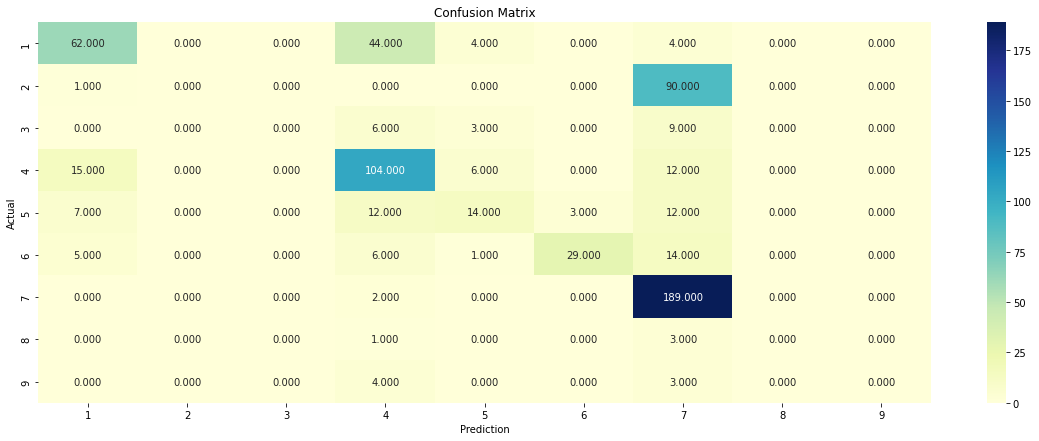

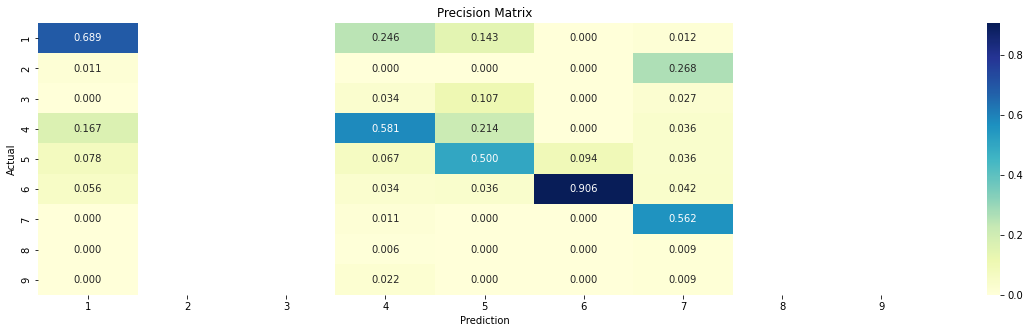

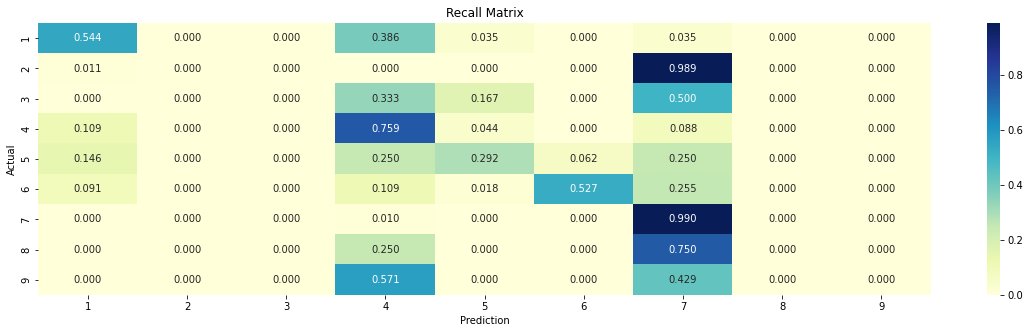

In [54]:
# Confusion matrix for Logistic Regression:
y_pred_rf = rf_best.predict(X_test)
x2 = conufsion_precision_recall(y_test,y_pred_rf)
x2